# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd

import torch
from torch_geometric.datasets import QM9

from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.test_functions.synthetic import Rosenbrock, Michalewicz
from gpytorch.mlls import ExactMarginalLogLikelihood

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

# Dataset

In [110]:
df = pd.read_csv("data/zinc250k.csv")

df.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [112]:
smiles = list(df.smiles)
smiles[5]

'CC[NH+](CC)[C@](C)(CC)[C@H](O)c1cscc1Br'

In [113]:
from src.encoder import SmilesEncoder

encoder = SmilesEncoder()

In [114]:
smi = smiles[5]
smi

'CC[NH+](CC)[C@](C)(CC)[C@H](O)c1cscc1Br'

In [115]:
z = encoder.encode_one_hot(smi)

In [120]:
one_hots = encoder.encode_dataset(smiles[:1000])

True

## Flory

In [5]:
n_components = 2
objective = FloryHuggins(n_components)
objective.set_size(0, 1)
objective.set_pairwise(0, 1, 3.0)

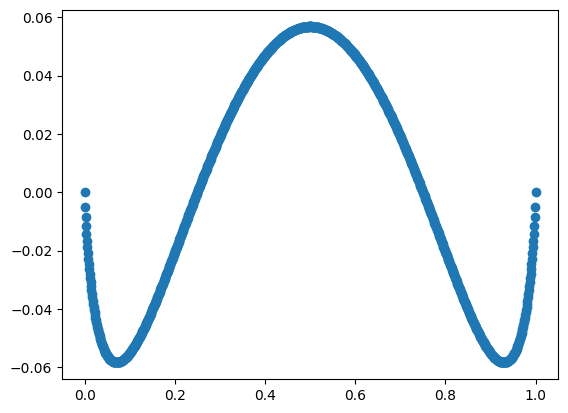

In [6]:
n = 1000

x0 = torch.linspace(0.0, 1.0, n)
x1 = 1.0 - x0

x = torch.stack([x0, x1], dim=1)
y = objective(x)

plt.scatter(x[:,1], y)
plt.show()